In [ ]:
!pip install pyDOE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from pyDOE import lhs

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc

np.random.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
 # Neural Network
class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.ThermalDiffusivity = model_parameters["ThermalDiffusivity"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)


    def forward(self, x):
        lb = self.LowerBounds
        ub = self.UpperBounds
        x = 2*(x - lb)/(ub - lb) - 1
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def internalEnergyBalanceResidue(self, X, T):
        alpha = self.ThermalDiffusivity

        # Compute the derivatives of the output w.r.t. the inputs (space and time) using AD mechanism:
        diff_T = torch.autograd.grad(T, X, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        Tx, Tt = diff_T[:, 0:1], diff_T[:, 1:2]

        # Compute the second derivative of the output w.r.t. the inputs (only space) using AD mechanism:
        Txx = torch.autograd.grad(Tx, X, create_graph=True, grad_outputs=torch.ones_like(T))[0][:, 0:1]

        residue = Tt - alpha*Txx
        return residue

## Problem data

In [ ]:
# Properties of pure solid aluminium
k = 210.0 # W/(m K)
C = 900.0 # J/(kg K)
rho = 2700.0 #kg/m^3
alpha = k/(rho*C)

# Boundaries of space and time domains
ti, tf = 0, 1000.0 # s
xi, xf = 0, 1.0 # m

# Non-dimensionalization
tf *= alpha
alpha = 1

lb = torch.tensor([xi, ti])
ub = torch.tensor([xf, tf])

# Initial and boundary temperatures
T_ref = 100.
bc_value = bc_value_l = bc_value_r = 300.0/T_ref # K
k1 = np.pi/xf
T_ampl = 100.0/T_ref # K
T0 = lambda x: T_ampl*torch.sin(k1*x) + bc_value # K

## Exact solution

In [ ]:
# Exact solution
T_exact = lambda x, t: T_ampl*np.sin(k1*x)*np.exp(-k1**2*alpha*t) + bc_value

# Grid for evaluation the exact solution
x_test = np.linspace(xi, xf, 1000)
t_test = np.linspace(ti, tf, 1000)
ms_x, ms_t = np.meshgrid(x_test, t_test)
x_test = np.ravel(ms_x).reshape(-1,1)
t_test = np.ravel(ms_t).reshape(-1,1)

T_ex_grid = T_exact(x_test, t_test).reshape(ms_x.shape)

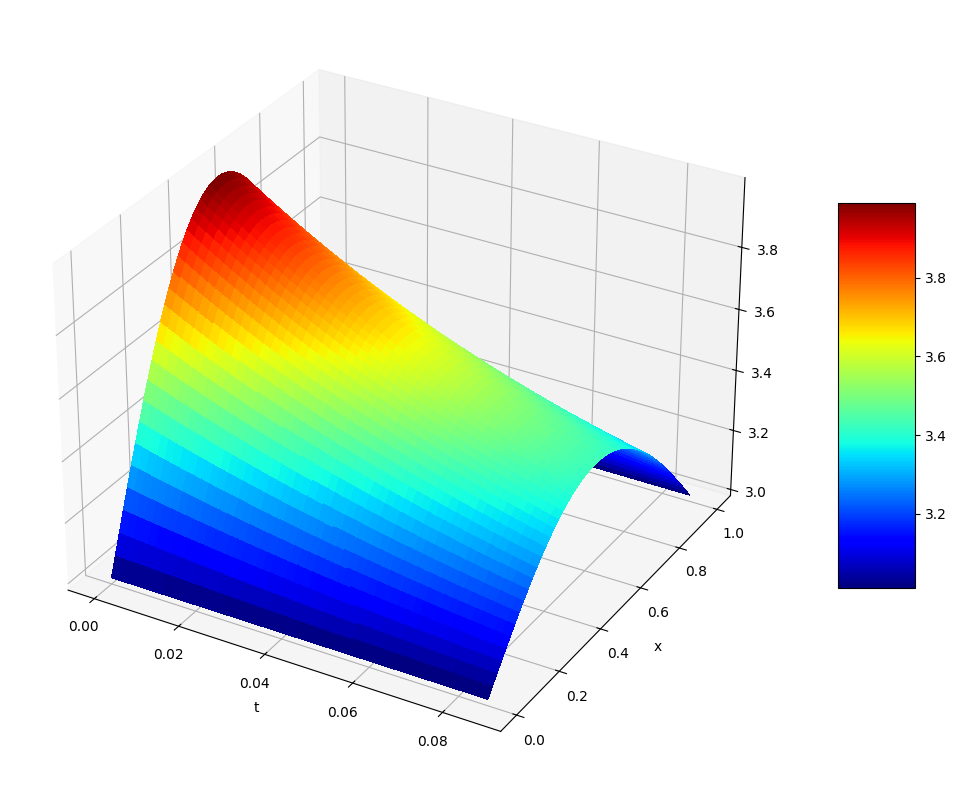

In [ ]:
# Plot the exact temperature distribution
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection = '3d')
#ax.view_init(elev=20, azim=-90)
surf1 = ax.plot_surface(ms_t, ms_x, T_ex_grid, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf1, shrink=0.5, aspect=5)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

## Datasets (collocation points and labelled data points)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx, :]
        target = self.y[idx, :]
        return features, target

In [ ]:
# Generate equispaced tensors for both space and time domains to pick from
x_tensor = torch.linspace(xi, xf, 10000, device=device)
t_tensor = torch.linspace(ti, tf, 10000, device=device)

# Number of collocation points
N_dom = 1000 # Number of collocation points for evaluating the residuals
N_bc = 300 # Number of collocation points for computing the boundary conditions
N_ic = 500 # Number of collocation points for computing the initial condition
N_data = 1000 # Number of labelled data points

# Train, validation and testing sets
tags = ["Domain", "BoundaryConditions", "InitialCondition"]
isData = False # Flag to indicate whether the analysis would use labelled data or not

# Initialize list of dataset objects
ds = []

In [ ]:
## Collocation points for evaluating the residual of the governing PDE

# Generate collocation points within the domain using Latin Hypercube Sampling (LHS) strategy
X_dom = (lb + (ub - lb)*lhs(2, N_dom)).to(torch.float32).to(device)
y_dom = torch.zeros((N_dom, 1), device=device)

# Generate random collocation points for the left boundary to add to the domain dataset
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_l = t_tensor[idx_bc].view(-1, 1)
x_bc_l = xi*torch.ones((N_bc, 1), device=device)
X_bc_l = torch.cat([x_bc_l, t_bc_l], axis=1)
y_bc_l = torch.zeros((N_bc, 1), device=device)

# Generate random collocation points for the right boundary to add to the domain dataset
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_r = t_tensor[idx_bc].view(-1, 1)
x_bc_r = xf*torch.ones((N_bc, 1), device=device)
X_bc_r = torch.cat([x_bc_r, t_bc_r], axis=1)
y_bc_r = torch.zeros((N_bc, 1), device=device)

# Generate collocation points for the initial condition to add to the domain dataset
idx_ic = np.random.choice(x_tensor.size()[0], N_ic, replace=False)
x_ic = x_tensor[idx_ic].view(-1, 1)
t_ic = ti*torch.ones((N_ic, 1), device=device)
X_ic = torch.cat([x_ic, t_ic], axis=1)
y_ic = torch.zeros((N_ic, 1), device=device)

# Concatenate X_dom dataset
X_dom = torch.cat([X_dom, X_bc_l, X_bc_r, X_ic], axis=0)
y_dom = torch.cat([y_dom, y_bc_l, y_bc_r, y_ic], axis=0)
ds.append(CustomDataset(X_dom, y_dom))

In [ ]:
## Collocation points for evaluating the boundary and initial conditions

# Generate random collocation points for the left boundary
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_l = t_tensor[idx_bc].view(-1, 1)
x_bc_l = xi*torch.ones((N_bc, 1), device=device)
X_bc_l = torch.cat([x_bc_l, t_bc_l], axis=1)
y_bc_l = torch.full((N_bc, 1), bc_value_l)

# Generate random collocation points for the right boundary
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_r = t_tensor[idx_bc].view(-1, 1)
x_bc_r = xf*torch.ones((N_bc, 1), device=device)
X_bc_r = torch.cat([x_bc_r, t_bc_r], axis=1)
y_bc_r = torch.full((N_bc, 1), bc_value_r)

# Concatenate the collocation points of both boundaries
X_bc = torch.cat([X_bc_l, X_bc_r], axis=0)
y_bc = torch.cat([y_bc_l, y_bc_r], axis=0)
ds.append(CustomDataset(X_bc, y_bc))

# Generate collocation points for the initial condition
idx_ic = np.random.choice(x_tensor.size()[0], N_ic, replace=False)
x_ic = x_tensor[idx_ic].view(-1, 1)
t_ic = ti*torch.ones((N_ic, 1), device=device)
X_ic = torch.cat([x_ic, t_ic], axis=1)
y_ic = T0(x_ic)
ds.append(CustomDataset(X_ic, y_ic))

In [ ]:
# Generate syntetic temperature labelled data
if isData:
    tags.append("LabelledData")
    idx_data = np.random.choice(x_tensor.size()[0], N_data, replace=False)
    omega = 0.01
    sensor_loc = 0.5
    x_data = torch.full((N_data, 1), sensor_loc, device=device)
    t_data = t_tensor[idx_data].view(-1, 1)
    X_data = torch.cat([x_data, t_data], axis=1)
    exact_temp_data = T_exact(x_data.data.cpu().numpy(), t_data.data.cpu().numpy())
    noisy_temp_data = exact_temp_data + omega*np.max(exact_temp_data)*np.random.normal(size=(N_data, 1))
    y_data = torch.from_numpy(noisy_temp_data).to(torch.float32).to(device)
    ds.append(CustomDataset(X_data, y_data))


In [ ]:
# Dictionary of dataset objects
datasets = dict(zip(tags, ds))

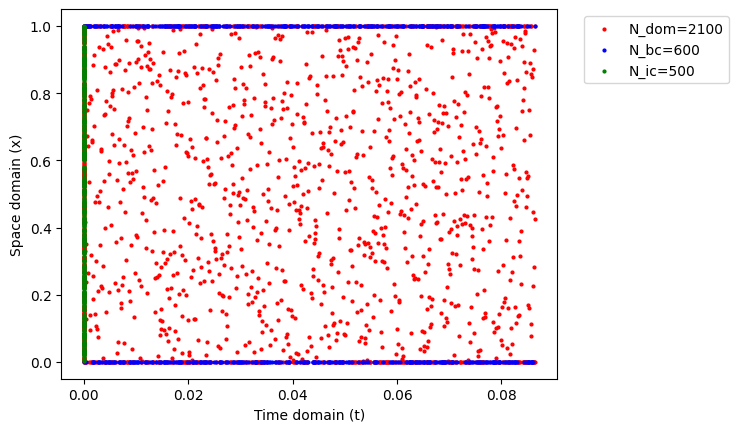

In [ ]:
# Plot the locations of the collocation points in the space-time domain
X_dom_train = (datasets["Domain"].X).data.cpu().numpy()
X_bc_train = (datasets["BoundaryConditions"].X).data.cpu().numpy()
X_ic_train = (datasets["InitialCondition"].X).data.cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_dom_train[:, 1:2], X_dom_train[0:, 0:1], s=4, c='r', label=f'N_dom={len(X_dom_train)}')
ax.scatter(X_bc_train[:, 1:2], X_bc_train[:, 0:1], s=4, c='b', label=f'N_bc={len(X_bc_train)}')
ax.scatter(X_ic_train[:, 1:2], X_ic_train[:, 0:1], s=4, c='g', label=f'N_ic={len(X_ic_train)}')
if isData:
    X_data_train = (datasets["LabelledData"].X).data.cpu().numpy()
    y_data_train = (datasets["LabelledData"].y).data.cpu().numpy()
    ax.scatter(X_data_train[:, 1:2], X_data_train[:, 0:1], s=4, c='m', label=f'N_Data={len(X_data_train)}', marker='x')
ax.legend()
plt.xlabel('Time domain (t)')
plt.ylabel('Space domain (x)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [ ]:
if isData:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    t_data = np.linspace(ti, tf, 1000).reshape(-1, 1)
    T_ex = T_exact(np.full((1000, 1), sensor_loc), t_data)
    ax.plot(t_data, T_ex, c='k', label='T. exact')
    ax.scatter(X_data_train[:, 1:2], y_data_train, s=4, c='m', label='T. noisy')
    ax.legend()
    plt.xlabel('Time domain (t)')
    plt.ylabel('Temperature (T)')
    plt.title(f'Temperature at sensor location (x_s={sensor_loc})')
    plt.show()

## Main execution

In [ ]:
# Input dictionary for model instance
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "ThermalDiffusivity": alpha,
    "InputDimensions": 2,
    "OutputDimensions": 1,
    "NumberOfNeurons": 20,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.Tanh()
}

In [ ]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

In [ ]:
# Model construction
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [ ]:
# Fitting stage
t0 = datetime.now()
data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

epochs = 10000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_train = []
loss_train_dom = []
loss_train_bc = []
loss_train_ic = []
loss_train_data = []
train_keys = ['Overall', 'Domain', 'BC', 'IC', 'Data']
for epoch in range(epochs):
    loss_list = []
    optimizer.zero_grad()
    for tag in tags:
        X = (datasets[tag].X).to(device)
        y = (datasets[tag].y).to(device)
        if tag=='Domain':
            X.requires_grad = True
            T = model(X)
            y_hat = model.internalEnergyBalanceResidue(X, T)
            loss = loss_fn(y_hat, y)
            loss_list.append(loss)

        else:
            T = model(X)
            loss = loss_fn(T, y)
            loss_list.append(loss)

    loss = sum(loss_list)
    loss.backward()
    optimizer.step()

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    loss_train_bc.append(loss_list[2].item())
    loss_train_ic.append(loss_list[3].item())
    if isData:
        loss_train_data.append(loss_list[4].item())

    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)

elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

##TRAIN## Adam - Epoch: 0, Overall: 1.96739e+01, Domain: 8.39413e+00, BC: 3.88863e+00, IC: 7.39112e+00, 
##TRAIN## Adam - Epoch: 100, Overall: 6.32901e+00, Domain: 2.47295e-01, BC: 1.96981e+00, IC: 4.11191e+00, 
##TRAIN## Adam - Epoch: 200, Overall: 3.52326e+00, Domain: 2.03588e-01, BC: 8.77145e-01, IC: 2.44253e+00, 
##TRAIN## Adam - Epoch: 300, Overall: 1.83556e+00, Domain: 1.31905e-01, BC: 3.04371e-01, IC: 1.39929e+00, 
##TRAIN## Adam - Epoch: 400, Overall: 9.36234e-01, Domain: 8.03974e-02, BC: 6.23730e-02, IC: 7.93463e-01, 
##TRAIN## Adam - Epoch: 500, Overall: 5.22219e-01, Domain: 5.02581e-02, BC: 1.17519e-03, IC: 4.70786e-01, 
##TRAIN## Adam - Epoch: 600, Overall: 3.58999e-01, Domain: 3.47093e-02, BC: 1.35662e-02, IC: 3.10724e-01, 
##TRAIN## Adam - Epoch: 700, Overall: 3.02719e-01, Domain: 2.65245e-02, BC: 4.11439e-02, IC: 2.35051e-01, 
##TRAIN## Adam - Epoch: 800, Overall: 2.83794e-01, Domain: 2.13472e-02, BC: 6.22443e-02, IC: 2.00203e-01, 
##TRAIN## Adam - Epoch: 900, Overall: 2

## Loss functions

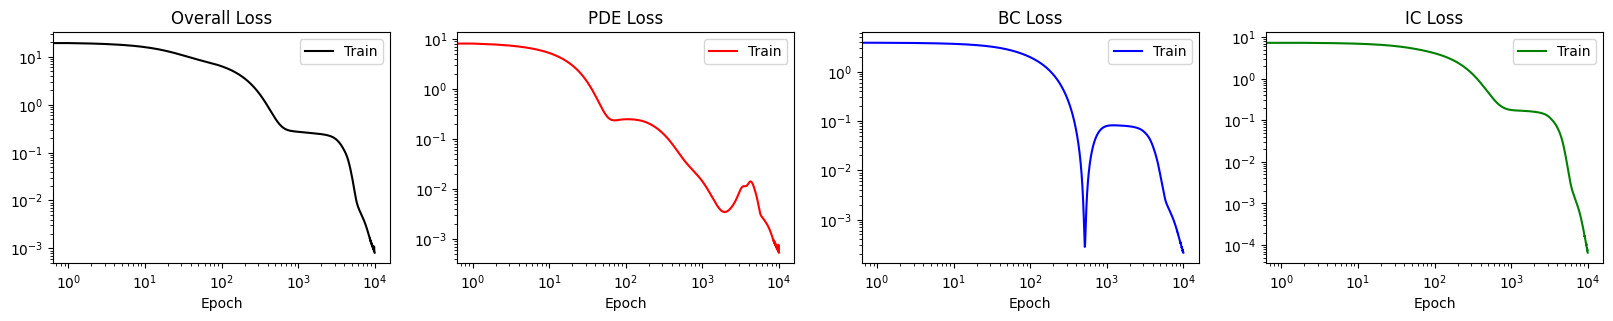

In [ ]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom, loss_train_bc, loss_train_ic]
colors = ['black', 'red', 'blue', 'green']
titles = ['Overall Loss', 'PDE Loss', 'BC Loss', 'IC Loss']
if isData:
    loss_train_list.append(loss_train_data)
    colors.append('magenta')
    titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].loglog(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

## Prediction

In [ ]:
# Definition of tensors from the testing points for evaluating the trained PINN
pt_x = torch.from_numpy(x_test).float()
pt_t = torch.from_numpy(t_test).float()
ms_Tex = T_exact(x_test, t_test).reshape(ms_x.shape)

In [ ]:
# Predicted solution
X_pred = torch.cat([pt_x, pt_t], axis=1).to(device)
Tpred = model(X_pred).data.cpu().numpy()
ms_Tpred = Tpred.reshape(ms_x.shape)

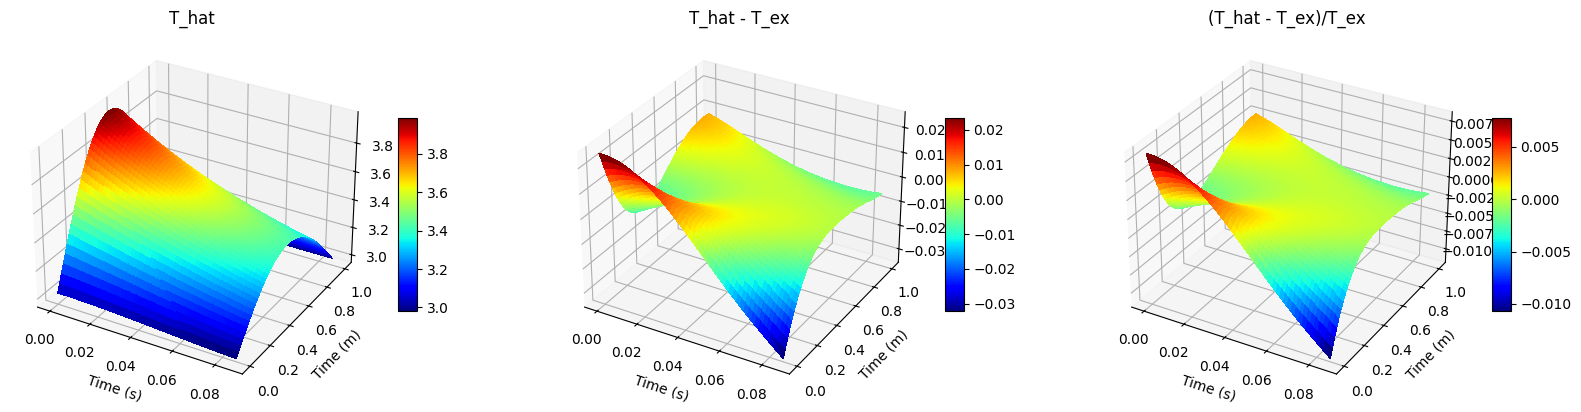

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
ax = axs[0]
surf = ax.plot_surface(ms_t, ms_x, ms_Tpred, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('T_hat')
ax = axs[1]
surf = ax.plot_surface(ms_t, ms_x, ms_Tpred-ms_Tex, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('T_hat - T_ex')
ax = axs[2]
surf = ax.plot_surface(ms_t, ms_x, (ms_Tpred-ms_Tex)/ms_Tex, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('(T_hat - T_ex)/T_ex')
plt.show()

## Loss landscape

In [ ]:
def plot_loss_landscape(model, loss_fn, datasets, num_points=20, alpha=1.0):
    # Store original parameters
    original_params = [p.clone() for p in model.parameters()]

    # Calculate two random directions
    direction1 = [torch.randn_like(p) for p in model.parameters()]
    direction2 = [torch.randn_like(p) for p in model.parameters()]

    # Normalize directions
    norm1 = torch.sqrt(sum(torch.sum(d**2) for d in direction1))
    norm2 = torch.sqrt(sum(torch.sum(d**2) for d in direction2))
    direction1 = [d / norm1 for d in direction1]
    direction2 = [d / norm2 for d in direction2]

    # Create grid
    x = np.linspace(-alpha, alpha, num_points)
    len(x)
    y = np.linspace(-alpha, alpha, num_points)
    X, Y = np.meshgrid(x, y)

    # Calculate loss for each point
    Z = np.zeros_like(X)
    for i in range(num_points):
        for j in range(num_points):
            # Update model parameters
            for p, d1, d2 in zip(model.parameters(), direction1, direction2):
                p.data = p.data + X[i, j] * d1 + Y[i, j] * d2

            # Calculate loss
            loss_list = []
            for tag in tags:
                X_data = (datasets[tag].X).to(device)
                y_data = (datasets[tag].y).to(device)
                if tag=='Domain':
                    X_data.requires_grad = True
                    T = model(X_data)
                    y_hat = model.internalEnergyBalanceResidue(X_data, T)
                    loss = loss_fn(y_hat, y_data)
                    loss_list.append(loss)

                else:
                    T = model(X_data)
                    loss = loss_fn(T, y_data)
                    loss_list.append(loss)

            loss = sum(loss_list)
            Z[i, j] = loss.item()

            '''total_loss = 0
            num_batches = 0
            for batch in dataloader:
                inputs, targets = batch
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                total_loss += loss.item()
                num_batches += 1
            Z[i,j] = total_loss / num_batches'''

            # Reset model parameters
            for p, orig_p in zip(model.parameters(), original_params):
                p.data = orig_p.clone()

    # Plot the loss landscape
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Direction 1')
    ax.set_ylabel('Direction 2')
    ax.set_zlabel('Loss')
    ax.set_title('Loss Landscape')
    fig.colorbar(surf)

    # Save the plot to a buffer
    #buf = io.BytesIO()
    #plt.savefig(buf, format='png')
    #buf.seek(0)

    # Close the plot to free up memory
    #plt.close(fig)

    return 0

'''
def log_loss_landscape(model, loss_fn, dataloader, step):
    # Generate the loss landscape plot
    buf = plot_loss_landscape(model, loss_fn, dataloader)

    # Log the plot to wandb
    wandb.log({
        "loss_landscape": wandb.Image(buf, caption="Loss Landscape"),
        "step": step
    })'''

'\ndef log_loss_landscape(model, loss_fn, dataloader, step):\n    # Generate the loss landscape plot\n    buf = plot_loss_landscape(model, loss_fn, dataloader)\n    \n    # Log the plot to wandb\n    wandb.log({\n        "loss_landscape": wandb.Image(buf, caption="Loss Landscape"),\n        "step": step\n    })'

0

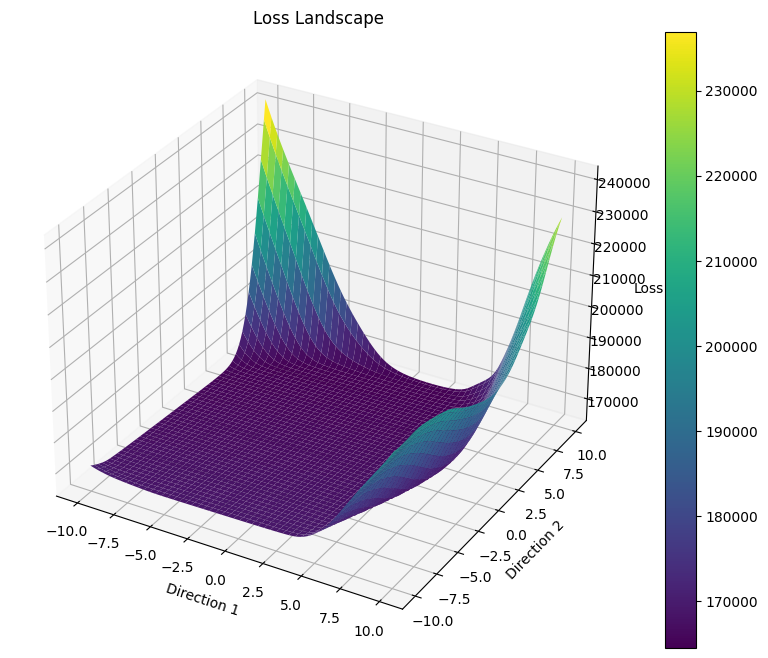

In [ ]:
plot_loss_landscape(model, loss_fn, datasets, 100, 10)